In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import norm
import statsmodels.stats.api as sms

from IPython.display import HTML

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Suppose we are given a set of data and we know it is created from a logistic style differential equation.
 We want to estimate the parameter $\lambda$ and $K$ from the data. First, we know the form of the solution of the differential equation, namely : $$ x(t) = \frac{Ce^{\lambda t}}{1 + \frac{C}{K}e^{\lambda t}}, \quad C=\frac{Kx(0)}{K-x(0)}$$.

When the differential equation takes the form of : $$\frac{dx}{dt} = \lambda x(1 - \frac{x}{K}), \quad \text{with} \quad x(0)=x_0 $$. 


## Priors and Model

We want to specify pior distributions for the parameters $\lambda$ and $K$. Here, they are a priori independent.


$$ \lambda \sim \text{N}(\mu_0, \sigma_0^2) \quad \text{and} \quad K \sim \text{Norm} ( \mu_1, \sigma_1^2) $$

We will generate some random experimental data of m observations, $\mathbf{y}$ below. We assume that this data is normally distributed around the true solution of the logistic equation with a known variance.

$$ y_i = x(t_i) + \epsilon_i $$ where $\epsilon_i, ..., \epsilon_m \sim  \text{Norm} ( 0 , \tau^2) $

In [2]:
random.seed(2018)
mu_0 = 1
mu_1 = 5.0
sig_0 = 0.3
sig_1 = 1

true_lambda = np.random.normal(mu_0, sig_0)

true_K = np.random.normal(mu_1, sig_1)

t_values = np.linspace(-5,15,51)

def diff_eqn_solution(true_lambda, carry_cap, t):
    return np.exp(true_lambda*t)/(1 + (1/true_K)*np.exp(true_lambda*t))

In [3]:
# Simulating what the true solution would be then adding the simulated gaussian noise 

sim_df = pd.DataFrame(index=t_values)
sim_df["true_values"] = diff_eqn_solution(true_lambda, true_K, sim_df.index)
sim_df["sim_values"] = np.zeros(len(sim_df.index))

tau = 0.3

for index, row in sim_df.iterrows():
    sim_df.loc[index, "sim_values"] = sim_df.loc[index, "true_values"] + np.random.normal(0, tau)

In [4]:
sim_df.head()

,true_values,sim_values
-5.0,0.008968,0.440755
-4.6,0.013061,0.008604
-4.2,0.019012,-0.203122
-3.8,0.027657,0.108215
-3.4,0.040194,0.227977


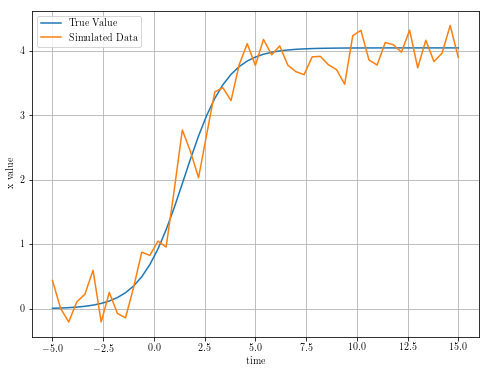

In [5]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8
fig_size[1] = 6

plt.plot(sim_df["true_values"])
plt.plot(sim_df["sim_values"])
plt.grid(True)
plt.xlabel("time")
plt.ylabel("x value")
plt.legend(["True Value", "Simulated Data"])
plt.show()

## Likelihood

$$ p(\lambda, K \mid \mathbf{y}) = \frac{p(\mathbf{y} \mid K, \lambda) p(K, \lambda)}{p(\mathbf{y})} =  \frac{p(\mathbf{y} \mid K, \lambda) p(K) p(\lambda)}{p(\mathbf{y})}$$

Now, we define the likelihood distribution. $Y_1, Y_2,..., Y_m$ are the random variables of the realisations/experimental data $ \mathbf{y} = (y_1, y_2,..., y_m)$ so that:

$$ Y_i \mid K, \lambda \sim \text{Norm}( x(t_i), \tau^2) $$

In [6]:
def likelihood(observation, lambda_value, k_value, t):
    return norm.pdf(observation, diff_eqn_solution(lambda_value, k_value, t), tau)

like_vec = np.vectorize(likelihood)

## Utilising the Grid Method

In [7]:
lam_grid = np.linspace(0,2, 101)
k_grid = np.linspace(1,9, 101)

prior_lam = np.array([norm.pdf(lam_grid, mu_0, sig_0)])
prior_k = np.array([norm.pdf(k_grid, mu_1, sig_1)])

prior = np.outer(prior_lam, prior_k)

In [8]:
prior

array([[  6.88011821e-07,   9.44453090e-07,   1.28820624e-06, ...,
          1.28820624e-06,   9.44453090e-07,   6.88011821e-07],
       [  8.57315520e-07,   1.17686102e-06,   1.60520382e-06, ...,
          1.60520382e-06,   1.17686102e-06,   8.57315520e-07],
       [  1.06354354e-06,   1.45995600e-06,   1.99133705e-06, ...,
          1.99133705e-06,   1.45995600e-06,   1.06354354e-06],
       ..., 
       [  1.06354354e-06,   1.45995600e-06,   1.99133705e-06, ...,
          1.99133705e-06,   1.45995600e-06,   1.06354354e-06],
       [  8.57315520e-07,   1.17686102e-06,   1.60520382e-06, ...,
          1.60520382e-06,   1.17686102e-06,   8.57315520e-07],
       [  6.88011821e-07,   9.44453090e-07,   1.28820624e-06, ...,
          1.28820624e-06,   9.44453090e-07,   6.88011821e-07]])

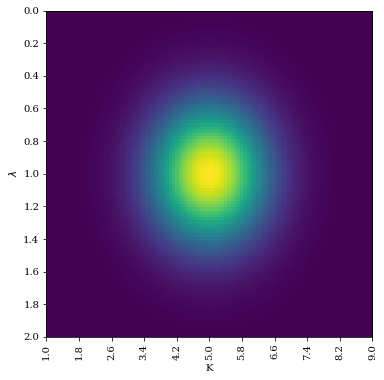

In [9]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

k_axis = []
for i in range(11):
    k_axis.append(k_grid[i*10])
    
lam_axis = []
for i in range(11):
    lam_axis.append(lam_grid[i*10])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(k_axis)
plt.xticks(range(len(k_axis)), rotation = 90)
ax.set_yticklabels(lam_axis)
plt.yticks(range(len(lam_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))
plt.xlabel("K")
plt.ylabel("$\lambda$")
plt.imshow(prior)
plt.show()

## Posterior

Typically we have to integrate the evidence term, $p(\mathbf{y})$, however since we are using the Grid method, we can discretize the integral and approximate it to a sum. 

$$ p(\mathbf{y}) = \iint p(\mathbf{y} \mid K, \lambda) p(K,\lambda) \: d\lambda dK \approx \sum\sum p(\mathbf{y} \mid K, \lambda) p(K,\lambda) \: \Delta K \Delta \lambda$$

In [30]:
for y_val in sim_df["sim_values"]:
    lik_mat = np.zeros((len(k_grid),len(lam_grid)))
    for j in range(len(lam_grid)):
        for l in range(len(k_grid)):
            lik_mat[j,l] = likelihood(y_val, lam_grid[j], k_grid[l], sim_df.index[sim_df["sim_values"] == y_val].values[0])
    lik_mat = np.nan_to_num(lik_mat)
    post_mat = (lik_mat * prior) / np.nan_to_num((lik_mat * prior).sum())
    post_mat = np.nan_to_num(post_mat)
    prior = post_mat

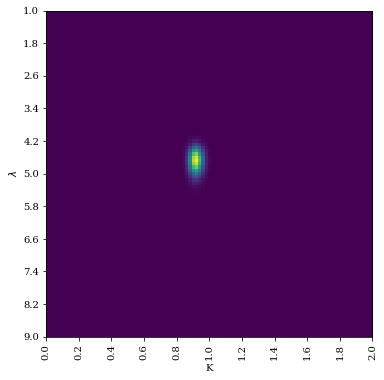

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(lam_axis)
plt.xticks(range(len(lam_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))
plt.xlabel("K")
plt.ylabel("$\lambda$")
plt.imshow(post_mat)
plt.show()

In [33]:
true_lambda

0.9423725136284996

In [34]:
true_K

4.048023299751731